**ABSTRACT**

*   A segmentation was carried out in 5 customer clusters of a department store
*   Model: Kmeans
*   Libraries used: Numpy, Pandas, MatPlotLib, Seaborn and Sklearn

# **1. PREPARATIONS**

---



## **1.1 Introduction**

K-means is a clustering algorithm used in unsupervised machine learning to group similar data points together. The algorithm is widely used for a variety of tasks, such as image segmentation, customer segmentation, and anomaly detection.

In K-means, the user specifies the number of clusters they want the algorithm to form. The algorithm then iteratively assigns each data point to the nearest centroid (mean) of a cluster and updates the centroid based on the mean of all the points assigned to that cluster. The algorithm continues this process until the centroids no longer change significantly or the maximum number of iterations is reached. The K-means algorithm can be sensitive to the initial position of the centroids, as it can get stuck in local optima. Therefore, multiple runs with different initializations are typically performed to find the best solution. Additionally, the user must specify the number of clusters they want the algorithm to form, which can be difficult if the optimal number of clusters is unknown.

'Customer Segmentation using K-Means', involves using the K-Means algorithm to group customers into distinct segments based on their purchasing behavior. The goal of this project is to help businesses better understand their customer base and tailor their marketing strategies and product offerings to specific segments.

## **1.2 Libraries import**

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

## **1.3 Files import**

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Mall_Customers.csv to Mall_Customers.csv


In [3]:
df_dir = "/content/Mall_Customers.csv"
df = pd.read_csv(df_dir)
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [5]:
df.shape

(200, 5)

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


In [7]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [8]:
df.duplicated().value_counts()

False    200
dtype: int64

# **2. EXPLORATORY DATA ANALYSIS**

---



## **2.1 Univariate analysis**

Univariate Analysis helps us to better understand all characteristics, on an individual scale. To dig even deeper into our knowledge and discover a potential pattern in the data, we will also have to find out more about the relationship between all these characteristics with each other, which is the next step in Bivariate Analysis

**Histogram**

Histograms are a useful tool for visualizing the distribution of a numeric variable. A histogram divides the values ​​into bins and shows how often the values ​​fall in each bin.

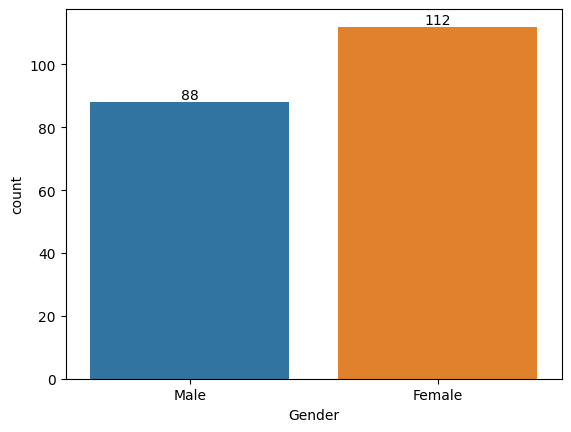

In [9]:
ax = sns.countplot(x='Gender', data=df)
ax.bar_label(container=ax.containers[0],labels = df['Gender'].value_counts(ascending = True))
plt.show()

**Boxplots**

Boxplots are also commonly used to understand the statistical characteristics of each feature. Most often, we use them to look for any outliers that we may need to filter out later during the preprocessing stage.

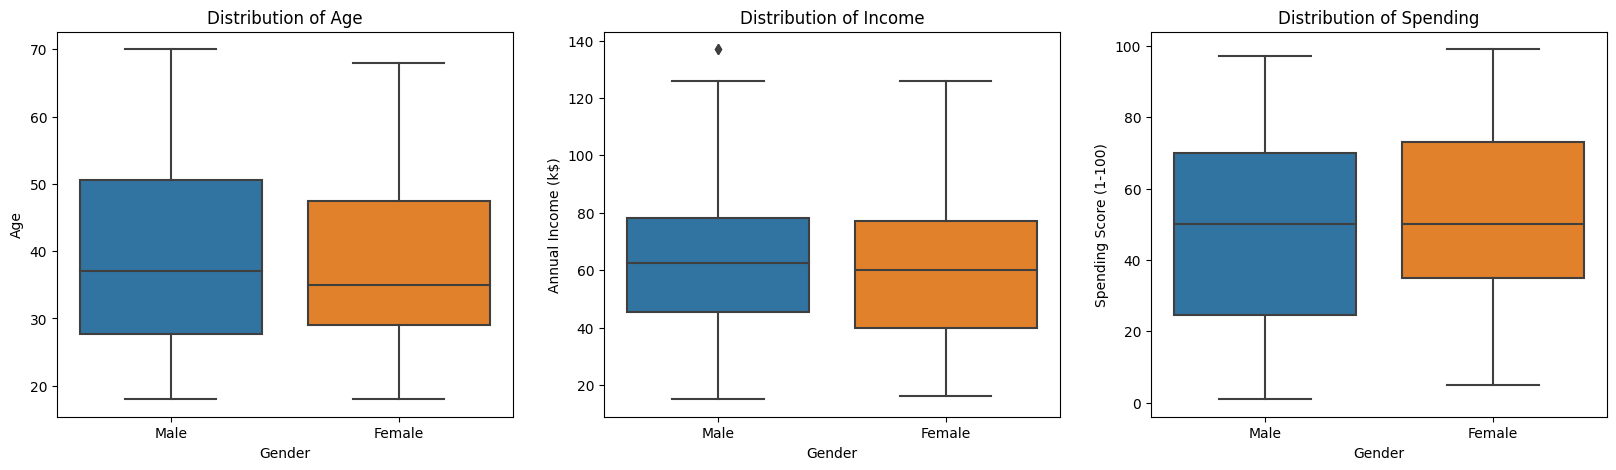

In [10]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.boxplot(x=df.Gender, y=df.Age)
plt.title('Distribution of Age')

plt.subplot(1,3,2)
sns.boxplot(x=df.Gender, y=df['Annual Income (k$)'])
plt.title('Distribution of Income')

plt.subplot(1,3,3)
sns.boxplot(x=df.Gender, y=df['Spending Score (1-100)'])
plt.title('Distribution of Spending')
plt.show()

## **2.2. Bivariate Analysis**

Bi-variate analysis looks at 2 different features to identify any possible relationship or distinctive patterns between the 2 features.

**Heatmap**


Heat maps are used to visualize the relationship between two categorical variables. Each cell in the heat map shows how often the two categories appear together in the observations.

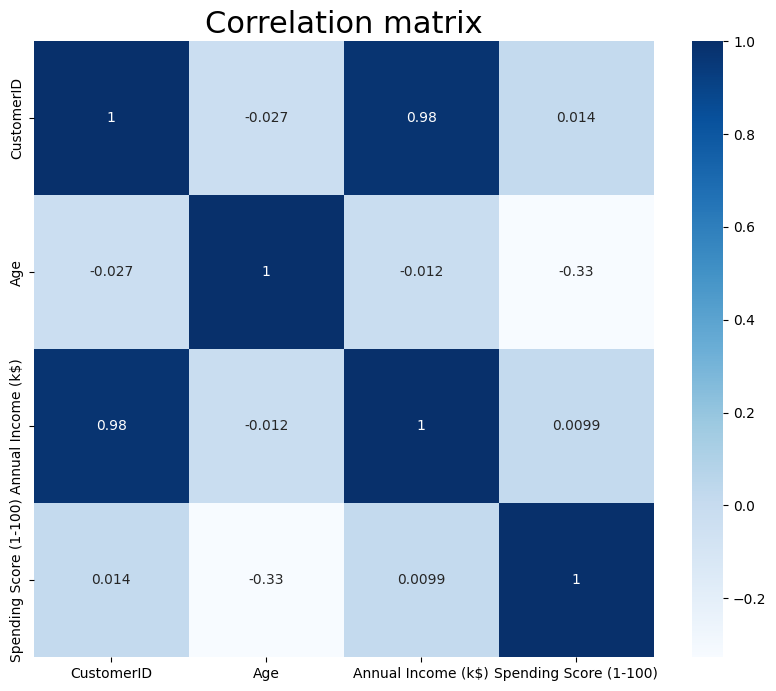

In [13]:
correlation = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation, annot=True, cmap="Blues")
plt.title("Correlation matrix", fontsize = 22)
plt.show()

**Scatter plot**

Scatter plots are used to visualize the relationship between two numerical variables. Each point on the graph represents an observation and the position of the point on the x-axis indicates the values ​​of the two variables.

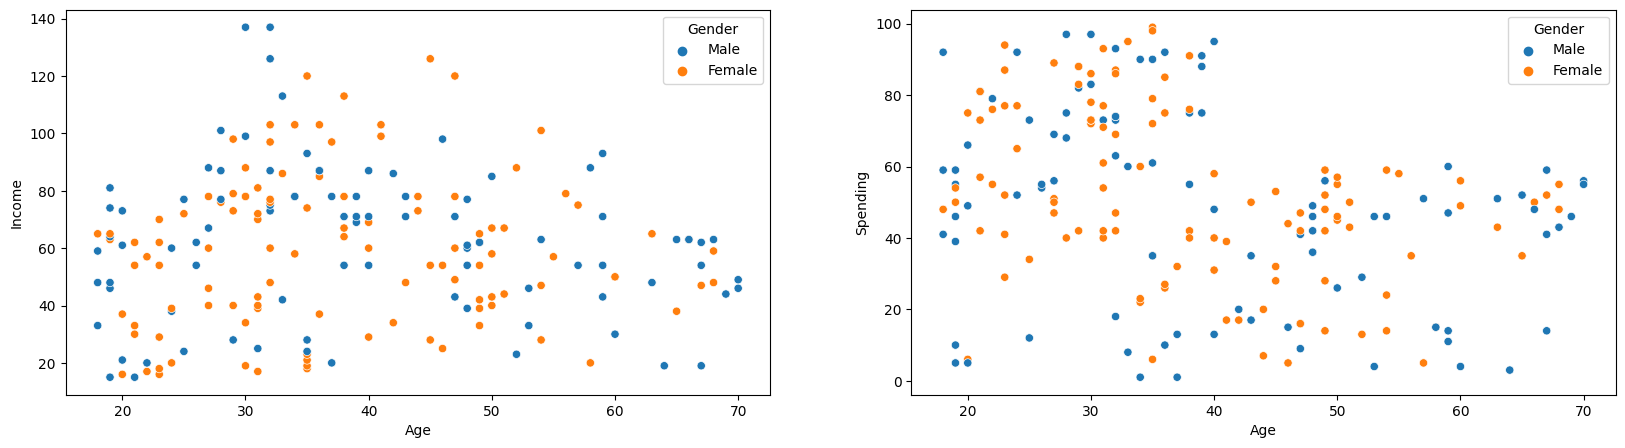

In [14]:
female = df[df.Gender == 'Female']
male = df[df.Gender == 'Male']

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.scatterplot(data = df, x='Age', y='Annual Income (k$)', hue='Gender')
plt.xlabel('Age')
plt.ylabel('Income')

plt.subplot(1,2,2)
sns.scatterplot(data = df, x='Age', y='Spending Score (1-100)', hue='Gender')
plt.xlabel('Age')
plt.ylabel('Spending')
plt.show()

# **3. DATA PREPROCESING**

## **3.1. Outliers**

Outliers are data points that have extreme values and they do not conform with the majority of the data. It is important to address this because outliers tend to skew our data towards extremes and can cause inaccurate model predictions. I will use the Tukey method to remove these outliers.

Here, we will write a function that will loop through a list of features and detect outliers in each one of those features. In each loop, a data point is deemed an outlier if it is less than the first quartile minus the outlier step or exceeds third quartile plus the outlier step. The outlier step is defined as 1.5 times the interquartile range. Once the outliers have been determined for one feature, their indices will be stored in a list before proceeding to the next feature and the process repeats until the very last feature is completed. Finally, using the list with outlier indices, we will count the frequencies of the index numbers and return them if their frequency exceeds n times.

In [15]:
from collections import Counter

In [16]:
def detect_outliers(df, n, features_list):
    outlier_indices = []
    for feature in features_list:
        Q1 = np.percentile(df[feature], 25)
        Q3 = np.percentile(df[feature], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[feature] < Q1 - outlier_step) | (df[feature] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(key for key, value in outlier_indices.items() if value > n)
    return multiple_outliers

outliers_to_drop = detect_outliers(df, 2, ['Age', 'Annual Income (k$)', 'Spending Score (1-100)'])
print("We will drop these {} indices: ".format(len(outliers_to_drop)), outliers_to_drop)

We will drop these 0 indices:  []


## **3.2. Missing values**

In [17]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

No missing values

# **4. MODELING**

---



## **4.1. KMeans Clustering**

In [18]:
x = df.iloc[:,[3,4]].values

In [19]:
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [20]:
x

array([[ 15,  39],
       [ 15,  81],
       [ 16,   6],
       [ 16,  77],
       [ 17,  40],
       [ 17,  76],
       [ 18,   6],
       [ 18,  94],
       [ 19,   3],
       [ 19,  72],
       [ 19,  14],
       [ 19,  99],
       [ 20,  15],
       [ 20,  77],
       [ 20,  13],
       [ 20,  79],
       [ 21,  35],
       [ 21,  66],
       [ 23,  29],
       [ 23,  98],
       [ 24,  35],
       [ 24,  73],
       [ 25,   5],
       [ 25,  73],
       [ 28,  14],
       [ 28,  82],
       [ 28,  32],
       [ 28,  61],
       [ 29,  31],
       [ 29,  87],
       [ 30,   4],
       [ 30,  73],
       [ 33,   4],
       [ 33,  92],
       [ 33,  14],
       [ 33,  81],
       [ 34,  17],
       [ 34,  73],
       [ 37,  26],
       [ 37,  75],
       [ 38,  35],
       [ 38,  92],
       [ 39,  36],
       [ 39,  61],
       [ 39,  28],
       [ 39,  65],
       [ 40,  55],
       [ 40,  47],
       [ 40,  42],
       [ 40,  42],
       [ 42,  52],
       [ 42,  60],
       [ 43,

In [21]:
wcss = []

for cluster in range(1,11):
    kmeans = KMeans(n_clusters = cluster, init = 'k-means++', random_state = 42)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)

In [22]:
wcss

[269981.28,
 181363.59595959593,
 106348.37306211122,
 73679.78903948836,
 44448.4554479337,
 37233.814510710006,
 30259.65720728547,
 25011.839349156588,
 21862.092672182895,
 19672.072849014323]

## **4.2. Choosing the Number of Clusters**

**Elbow method**

The idea behind the Elbow method is to find the value of "k" where increasing the number of clusters beyond that point does not significantly improve clustering performance.

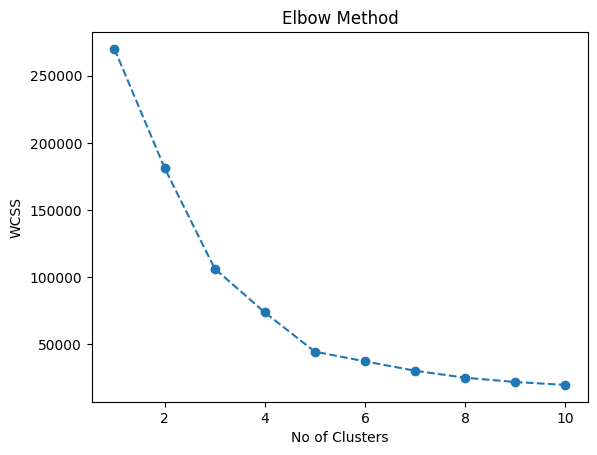

In [23]:
plt.plot(range(1,11), wcss, 'o--')
plt.title('Elbow Method')
plt.xlabel('No of Clusters')
plt.ylabel('WCSS')

plt.show()

In [24]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
y = kmeans.fit_predict(x)
y

array([2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 0,
       2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 4, 0, 4, 1, 4, 1, 4,
       0, 4, 1, 4, 1, 4, 1, 4, 1, 4, 0, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4,
       1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4,
       1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4,
       1, 4], dtype=int32)

In [25]:
df['Cluster'] = kmeans.labels_
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,Male,19,15,39,2
1,2,Male,21,15,81,3
2,3,Female,20,16,6,2
3,4,Female,23,16,77,3
4,5,Female,31,17,40,2


# **5. INTERPRETATION OF RESULTS**

---



## **5.1 Visualising the Clusters**

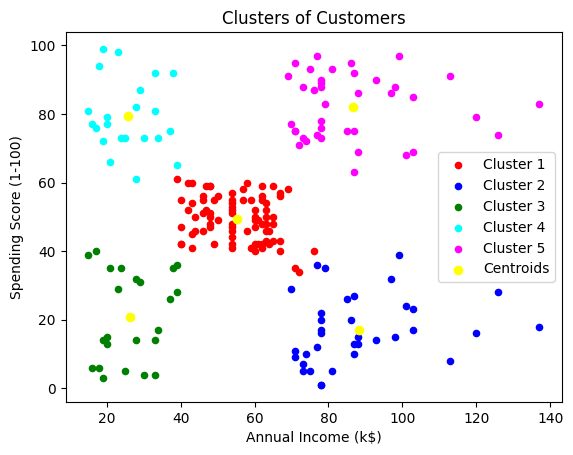

In [26]:
plt.scatter(x[y == 0, 0], x[y == 0, 1], s = 20, c = 'red', label = 'Cluster 1')
plt.scatter(x[y == 1, 0], x[y == 1, 1], s = 20, c = 'blue', label = 'Cluster 2')
plt.scatter(x[y == 2, 0], x[y == 2, 1], s = 20, c = 'green', label = 'Cluster 3')
plt.scatter(x[y == 3, 0], x[y == 3, 1], s = 20, c = 'cyan', label = 'Cluster 4')
plt.scatter(x[y == 4, 0], x[y == 4, 1], s = 20, c = 'magenta', label = 'Cluster 5')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c = 'yellow', label = 'Centroids')
plt.title('Clusters of Customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

In [27]:
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,Male,19,15,39,2
1,2,Male,21,15,81,3
2,3,Female,20,16,6,2
3,4,Female,23,16,77,3
4,5,Female,31,17,40,2
...,...,...,...,...,...,...
195,196,Female,35,120,79,4
196,197,Female,45,126,28,1
197,198,Male,32,126,74,4
198,199,Male,32,137,18,1


In [30]:
fig = px.scatter_3d(df, x='Age', y='Annual Income (k$)', z='Spending Score (1-100)',
              color='Cluster', opacity=0.7)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

## **5.2 Cluster Analysis**

<div class="alert alert-success">
    <b>Cluster 1:</b> Average Income, Average Spending Score <br>
    <b>Cluster 2:</b> High Income, Low Spending Score <br>
    <b>Cluster 3:</b> Low Income, Low Spending Score <br>
    <b>Cluster 4:</b> Low Income, High Spending Score <br>
    <b>Cluster 5:</b> High Income, High Spending Score <br>
</div>

In [31]:
oneData = df.iloc[y == 0, :]
twoData = df.iloc[y == 1, :]
threeData = df.iloc[y == 2, :]
fourData = df.iloc[y == 3, :]
fiveData = df.iloc[y == 4, :]

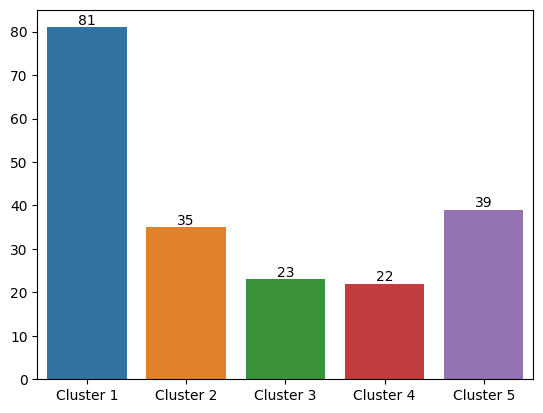

In [32]:
ax = sns.barplot(x = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'],
                 y = [len(oneData), len(twoData), len(threeData), len(fourData), len(fiveData)])
ax.bar_label(container = ax.containers[0],labels = [len(oneData), len(twoData), len(threeData), len(fourData), len(fiveData)])
plt.show()

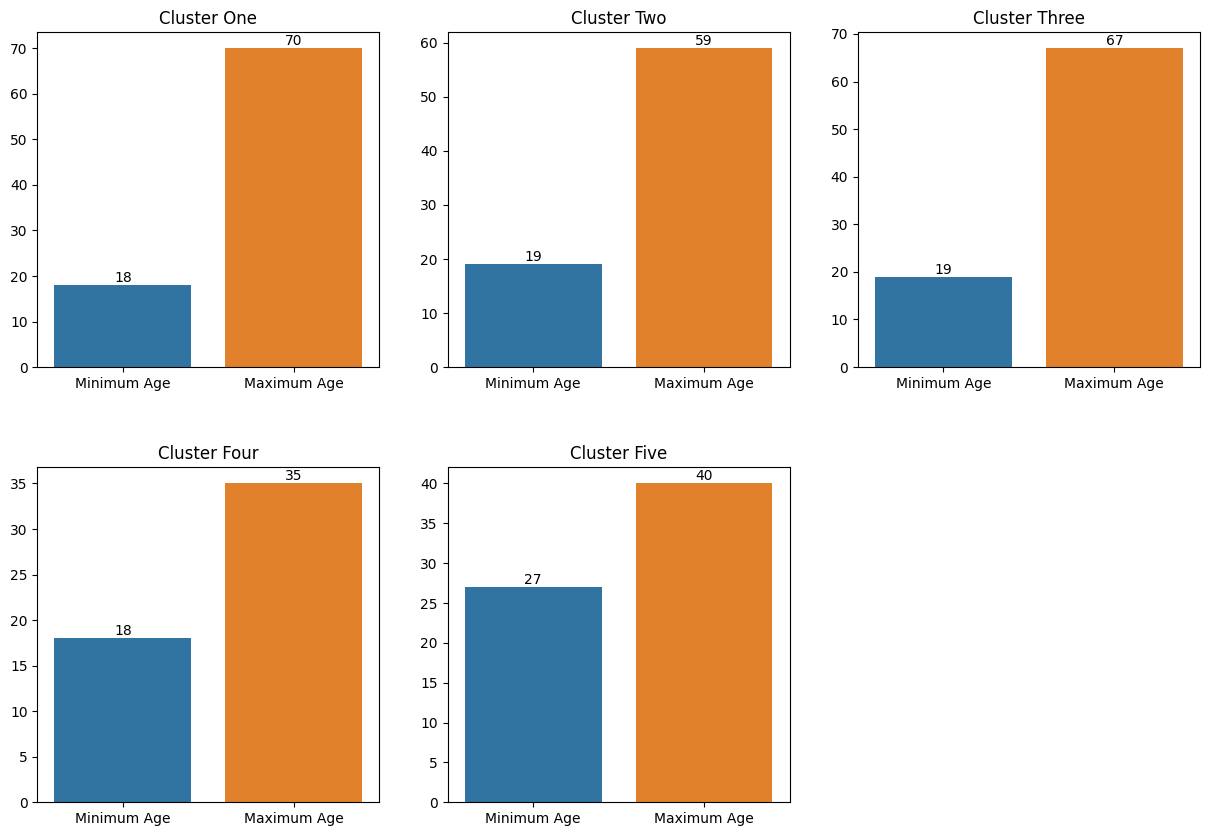

In [33]:
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
ax = sns.barplot(x = ['Minimum Age', 'Maximum Age'], y = [oneData['Age'].min(), oneData['Age'].max()])
ax.bar_label(container = ax.containers[0],labels = [oneData['Age'].min(), oneData['Age'].max()])
plt.title('Cluster One')

plt.subplot(2,3,2)
ax = sns.barplot(x = ['Minimum Age', 'Maximum Age'], y = [twoData['Age'].min(), twoData['Age'].max()])
ax.bar_label(container = ax.containers[0],labels = [twoData['Age'].min(), twoData['Age'].max()])
plt.title('Cluster Two')

plt.subplot(2,3,3)
ax = sns.barplot(x = ['Minimum Age', 'Maximum Age'], y = [threeData['Age'].min(), threeData['Age'].max()])
ax.bar_label(container = ax.containers[0],labels = [threeData['Age'].min(), threeData['Age'].max()])
plt.title('Cluster Three')

plt.subplot(2,3,4)
ax = sns.barplot(x = ['Minimum Age', 'Maximum Age'], y = [fourData['Age'].min(), fourData['Age'].max()])
ax.bar_label(container = ax.containers[0],labels = [fourData['Age'].min(), fourData['Age'].max()])
plt.title('Cluster Four')

plt.subplot(2,3,5)
ax = sns.barplot(x = ['Minimum Age', 'Maximum Age'], y = [fiveData['Age'].min(), fiveData['Age'].max()])
ax.bar_label(container = ax.containers[0],labels = [fiveData['Age'].min(), fiveData['Age'].max()])
plt.title('Cluster Five')
plt.subplots_adjust(wspace = 0.2, hspace = 0.3)
plt.show()

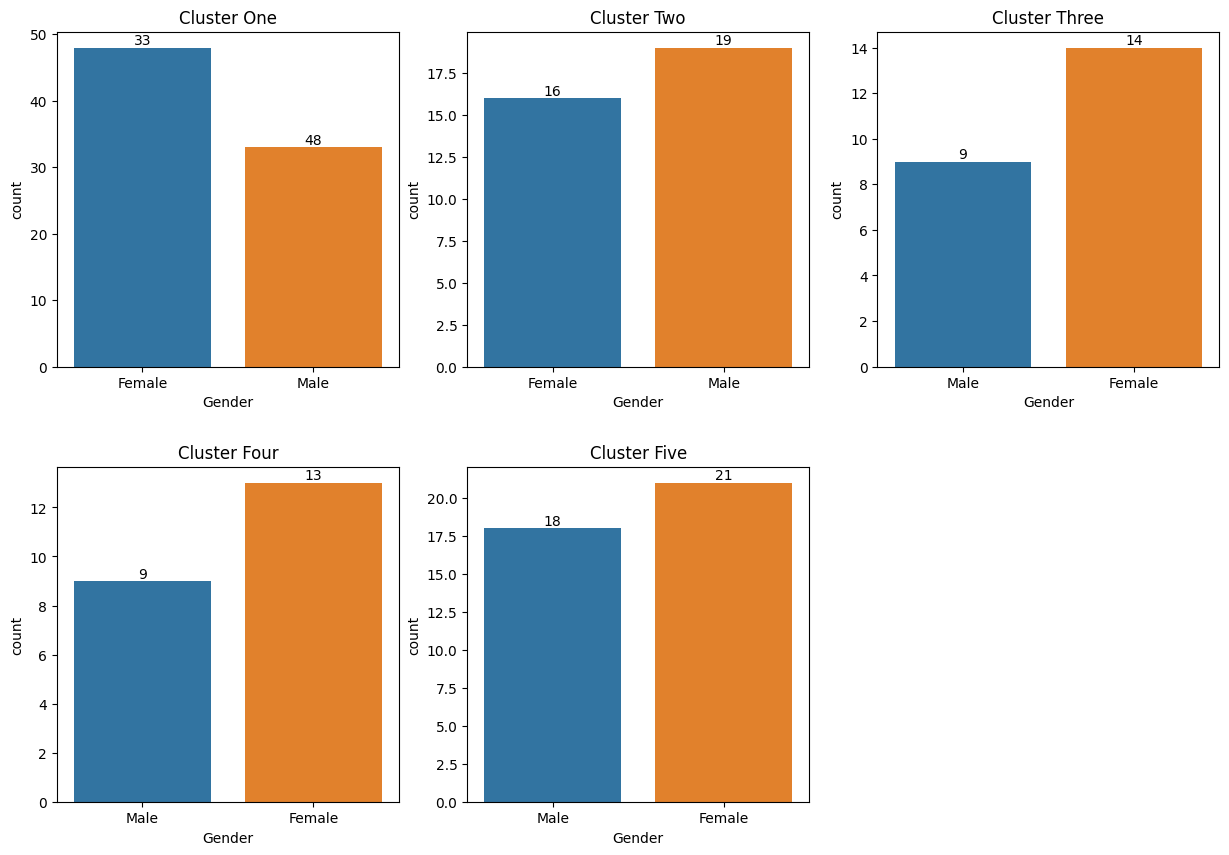

In [34]:
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
ax = sns.countplot(x = 'Gender', data = oneData)
ax.bar_label(container = ax.containers[0],labels = oneData['Gender'].value_counts(ascending = True))
plt.title('Cluster One')

plt.subplot(2,3,2)
ax = sns.countplot(x = 'Gender', data = twoData)
ax.bar_label(container = ax.containers[0],labels = twoData['Gender'].value_counts(ascending = True))
plt.title('Cluster Two')

plt.subplot(2,3,3)
ax = sns.countplot(x = 'Gender', data = threeData)
ax.bar_label(container = ax.containers[0],labels = threeData['Gender'].value_counts(ascending = True))
plt.title('Cluster Three')

plt.subplot(2,3,4)
ax = sns.countplot(x = 'Gender', data = fourData)
ax.bar_label(container = ax.containers[0],labels = fourData['Gender'].value_counts(ascending = True))
plt.title('Cluster Four')

plt.subplot(2,3,5)
ax = sns.countplot(x = 'Gender', data = fiveData)
ax.bar_label(container = ax.containers[0],labels = fiveData['Gender'].value_counts(ascending = True))
plt.title('Cluster Five')
plt.subplots_adjust(wspace = 0.2, hspace = 0.3)
plt.show()

## **5.3 Conclusion**

**Based on the analysis, these are the final observations from the dataset for each cluster:**

* Cluster 1 occupies the maximum amount of people that earn decent as well as spend a decent amount. They should be sent regular updates and promotional offers so as to keep their interest. <br>
* Cluster 2 has high income but they do not shop as much. These people should be targeted since they have the spending capactiy. Their past data should be analysed so as to send them specific promotional messages to get their interest back. <br>
* Cluster 3 should be ignored since they do not have the spending capacity nor do they show interest in spending. <br>
* Cluster 4 is a risky group since they do not have the spending capacity yet they have a high spending score. They should be sent more discount based coupons. <br>
* Cluster 5 is the best group since they have a high income and a high spending score as well. They should be sent regular updates and promotions.